In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function to read bounding boxes from a text file
def read_bounding_boxes(file_path, image_width, image_height):
    with open(file_path, 'r') as file:
        bounding_boxes = []
        for line in file:
            parts = line.strip().split()
            # Convert to absolute coordinates
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height
            # Convert from center to top-left corner
            x = int(x_center - (width / 2))
            y = int(y_center - (height / 2))
            bounding_boxes.append((x, y, int(width), int(height)))
    return bounding_boxes

# Data plotting and  Interpretation

Below the necessary functions to plot the images with their respective labels and bounding boxes are presented.

In [ ]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import seaborn as sns

In [ ]:
def parse_label_file(file_path):
    with open(file_path, 'r') as file:
        boxes = np.array([list(map(float, line.strip().split())) for line in file])
        if boxes.size == 0:
            return np.array([]), np.array([])
        labels = boxes[:,0].astype(int)
        boxes = boxes[:,1:]
    return labels, boxes

In [ ]:
def draw_bounding_boxes(image_path, label_path, save_fig = False):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Assuming you have a function to parse your label files
    labels, boxes = parse_label_file(label_path)

    # Get image dimensions
    height, width, _ = image.shape

    # Draw each bounding box
    for (label, box) in zip(labels[:3], boxes[:3]):
      # Unpack the normalized bbox coordinates from the label file
      x_center, y_center, w, h = box

      # Convert to pixel coordinates
      x1 = int((x_center - w / 2) * width)
      y1 = int((y_center - h / 2) * height)
      x2 = int((x_center + w / 2) * width)
      y2 = int((y_center + h / 2) * height)

      # Draw the rectangle on the image
      if label == 0:
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 2)
      else:
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    if save_fig == True:
      plt.savefig('/content/example_fig.png', dpi=300)



In [ ]:

# Each txt file contains the annotations for the corresponding image file
train_labels_path = "/content/drive/MyDrive/Final_Project_DNN/train/labels"
train_img_path = "/content/drive/MyDrive/Final_Project_DNN/train/images"
train_label_files = os.listdir(train_labels_path)
train_image_files = os.listdir(train_img_path)


Let's visualize an example wich includes both fire and smoke and the respective bounding boxes. The blue bounding box marks smoke and the red fire.

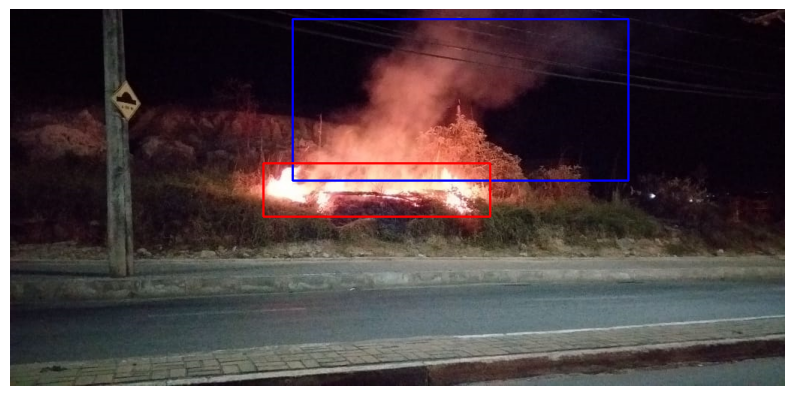

<Figure size 640x480 with 0 Axes>

In [ ]:
label_path = f"{train_labels_path}/{train_label_files[1001]}"
image_path = f"{train_img_path}/{train_label_files[1001][:-4]}.jpg"
draw_bounding_boxes(image_path, label_path, save_fig = True)

Below we can se an example that was probably used by the dataset creators in order to augmentate the smoke by introducing images with only smoke.

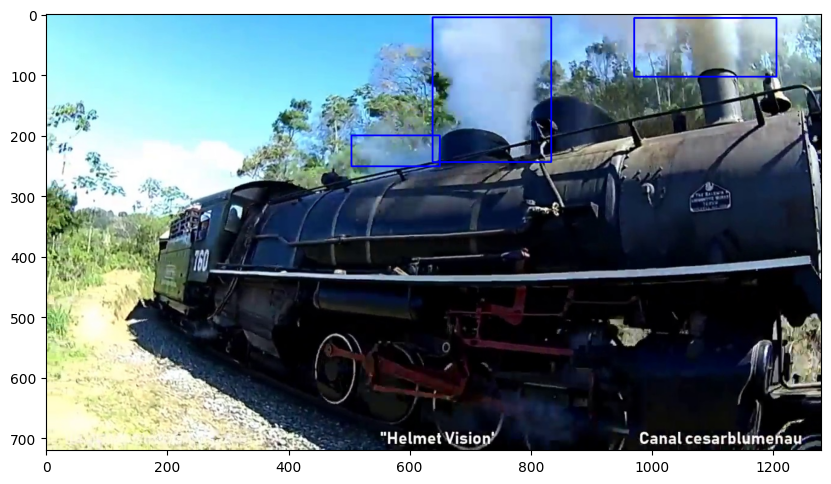

In [ ]:
label_path = f"{train_labels_path}/WEB09399.txt"
image_path = f"{train_img_path}/WEB09399.jpg"
draw_bounding_boxes(image_path, label_path)

## Descriptive Analysis

Below we create the function process_file in order to go through all the labels files and retrieve the necessary information in order to do the necessary plots. At the end we apply multiprocessing to go over the files in parallel resulting in faster running times.

In [ ]:
def process_file(label):
    img_id = label.split('.')[0] + '.jpg'
    label_path = os.path.join(train_labels_path, label)
    image_path = os.path.join(train_img_path, img_id)

    # Initialize local counters
    local_fire_count = 0
    local_smoke_count = 0
    local_both_count = 0

    # Initialize local grids
    local_heatmap_grid_fire = np.zeros((50, 50))
    local_heatmap_grid_smoke = np.zeros((50, 50))

    # Local lists to hold area and aspect ratio
    local_fire_areas = []
    local_fire_aspect_ratios = []
    local_smoke_areas = []
    local_smoke_aspect_ratios = []

    # Parsing labels from txt file
    label, box = parse_label_file(label_path)

    # Opening image
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape

    # Process each bounding box
    for class_id, bb in zip(label, box):
        x_center, y_center, width, height = bb

        # Calculate the absolute values of width and height
        abs_width = width * image_width
        abs_height = height * image_height

        # Skip if width or height is zero
        if abs_width == 0 or abs_height == 0:
            continue

        # Define coordinates to update in the grids
        grid_x = int(x_center * 50)
        grid_y = int(y_center * 50)

        # Process based on class_id
        if class_id == 1:  # 1 is for fire
            local_fire_count += 1
            local_fire_areas.append(width * height)
            local_fire_aspect_ratios.append(width / height)
            local_heatmap_grid_fire[grid_y, grid_x] += 1
        elif class_id == 0:  # 0 is for smoke
            local_smoke_count += 1
            local_smoke_areas.append(width * height)
            local_smoke_aspect_ratios.append(width / height)
            local_heatmap_grid_smoke[grid_y, grid_x] += 1

    return {
        'fire_count': local_fire_count,
        'smoke_count': local_smoke_count,
        'heatmap_grid_fire': local_heatmap_grid_fire,
        'heatmap_grid_smoke': local_heatmap_grid_smoke,
        'fire_areas': local_fire_areas,
        'fire_aspect_ratios': local_fire_aspect_ratios,
        'smoke_areas': local_smoke_areas,
        'smoke_aspect_ratios': local_smoke_aspect_ratios,
        'image_width': image_width,
        'image_height': image_height
    }

# Initialize total counters and lists
total_fire_count = 0
total_smoke_count = 0
total_heatmap_grid_fire = np.zeros((50, 50))
total_heatmap_grid_smoke = np.zeros((50, 50))
total_fire_areas = []
total_fire_aspect_ratios = []
total_smoke_areas = []
total_smoke_aspect_ratios = []
total_width = []
total_height = []

def aggregate_results(result):
    global total_fire_count, total_smoke_count
    global total_heatmap_grid_fire, total_heatmap_grid_smoke
    global total_fire_areas, total_fire_aspect_ratios
    global total_smoke_areas, total_smoke_aspect_ratios
    global total_width, total_height

    # Aggregate counts
    total_fire_count += result['fire_count']
    total_smoke_count += result['smoke_count']

    # Aggregate grids
    total_heatmap_grid_fire += result['heatmap_grid_fire']
    total_heatmap_grid_smoke += result['heatmap_grid_smoke']

    # Aggregate areas and aspect ratios
    total_fire_areas.extend(result['fire_areas'])
    total_fire_aspect_ratios.extend(result['fire_aspect_ratios'])
    total_smoke_areas.extend(result['smoke_areas'])
    total_smoke_aspect_ratios.extend(result['smoke_aspect_ratios'])

    # Aggregate width and height
    total_width.append(result["image_width"])
    total_height.append(result["image_height"])

# Use multiprocessing to process files in parallel
if __name__ == '__main__':
    with Pool(processes=cpu_count()) as pool:
        for result in tqdm(pool.imap_unordered(process_file, train_label_files), total=len(train_label_files)):
            aggregate_results(result)

 26%|██▌       | 4250/16221 [12:41<32:42,  6.10it/s]

Now let's just plot everything we need. The focus will be in visualizing the standardized size and aspect ratio of the bounding boxes as well as their location in the image. The aspect ratio does not change between both classes but the smoke bounding boxes size seem to spread wider than the fire ones.

One can see the smoke seems to be more spreaded through the image while the fire can be more commonly found in the upper part of the images and not as spreaded as the smoke.

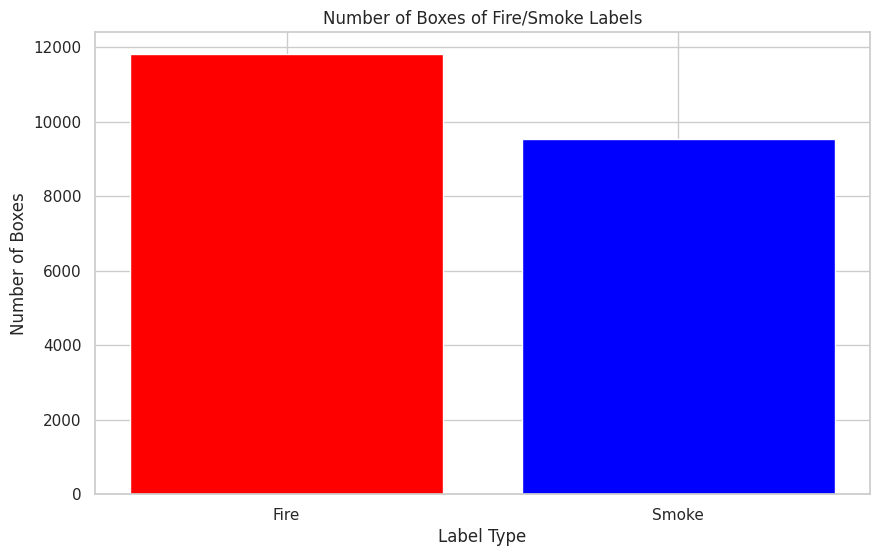

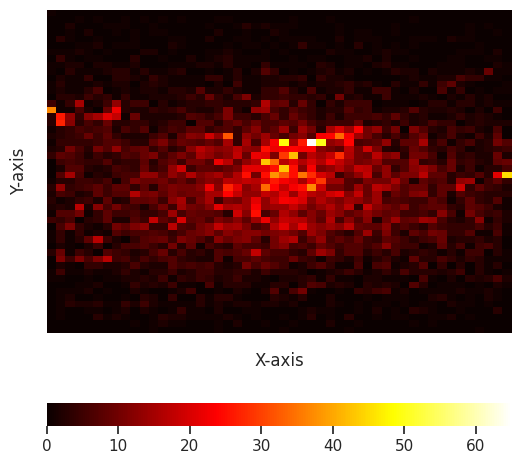

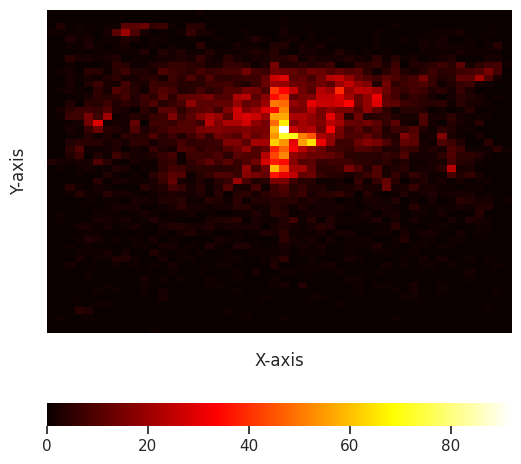

<Figure size 1200x600 with 0 Axes>

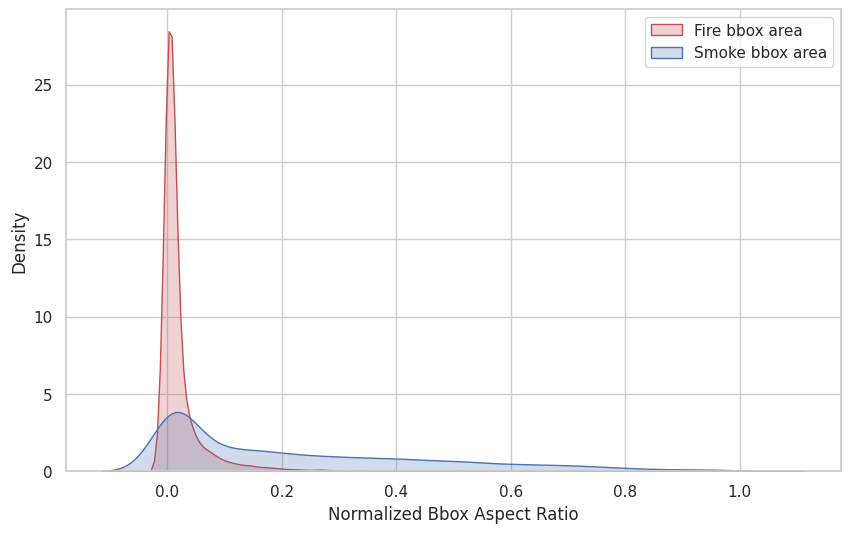

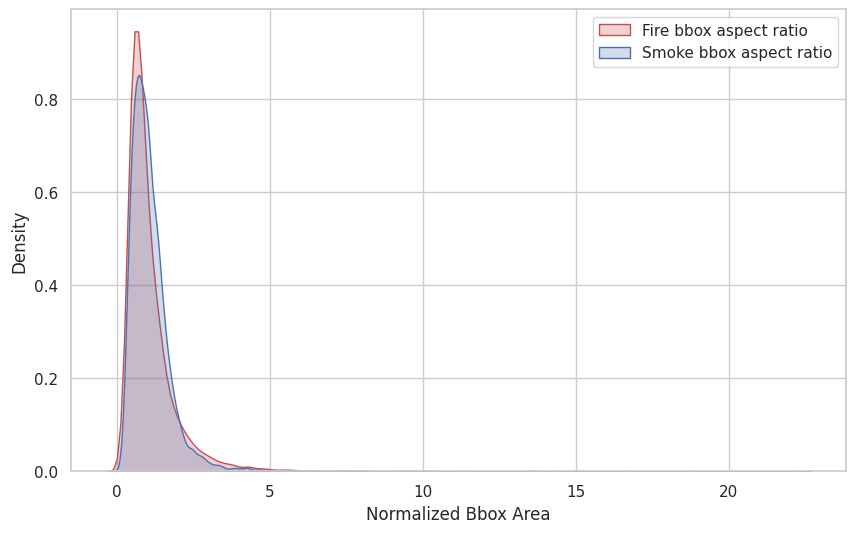

In [ ]:
# Now, let's create the bar plot for label counts
labels = ['Fire', 'Smoke']
counts = [total_fire_count, total_smoke_count]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=['red', 'blue'])
plt.title('Number of Boxes of Fire/Smoke Labels')
plt.xlabel('Label Type')
plt.ylabel('Number of Boxes')
plt.show()

# Next, we'll create the heatmaps

plt.figure(figsize=(6, 6))
ax = sns.heatmap(total_heatmap_grid_fire, cmap='hot', cbar_kws={"orientation": "horizontal"})
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False)
plt.show()


plt.figure(figsize=(6, 6))
ax = sns.heatmap(total_heatmap_grid_smoke, cmap='hot', cbar_kws={"orientation": "horizontal"})
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False)
plt.show()


# Finally, we will plot the density plot of area and aspect ratios
plt.figure(figsize=(12, 6))

# Plot for area

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(total_fire_areas, fill=True, color="r", label="Fire bbox area")
sns.kdeplot(total_smoke_areas, fill=True, color="b", label="Smoke bbox area")
plt.xlabel('Normalized Bbox Aspect Ratio')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot for aspect ratio

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(total_fire_aspect_ratios, fill=True, color="r", label="Fire bbox aspect ratio")
sns.kdeplot(total_smoke_aspect_ratios, fill=True, color="b", label="Smoke bbox aspect ratio")
plt.xlabel('Normalized Bbox Area')
plt.ylabel('Density')
plt.legend()
plt.show()
